# Ayush Thada
# 16BCE1333
# Assignement 2

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_df = pd.read_csv("Yes_Bank_Train.csv",)

In [3]:
print("Train Set Shape: {}".format(train_df.shape))

Train Set Shape: (17773, 56)


In [4]:
train_df.head()

,Serial Number,fund_symbol,fund_name,category,fund_family,investment,size,total_net_assets,currency,net_annual_expenses_ratio,...,returns_2012,returns_2011,returns_2010,morningstar_risk_rating,alpha_3y,beta_3y,mean_annual_return_3y,standard_deviation_3y,sharpe_ratio_3y,treynor_ratio_3y
0,1,AAAAX,Deutsche Real Assets A,World Allocation,Deutsche Asset Management,Blend,Large,486740000,USD,1.22,...,9.32,-3.46,12.20,3,-1.96,0.84,0.26,7.16,0.35,2.70
1,2,AAADX,Aberdeen Income Builder A,Large Blend,Aberdeen,Value,Large,9980000,USD,1.44,...,NaN,NaN,NaN,3,-4.84,1.00,0.51,10.62,0.51,5.04
2,3,AAAGX,Thrivent Large Cap Growth A,Large Growth,Thrivent,Growth,Large,997620000,USD,1.20,...,17.79,-6.29,9.70,4,1.04,1.10,1.08,12.91,0.96,11.15
3,4,AAAIX,American Century Strat Allc: Agrsv I,Allocation--70% to 85% Equity,American Century Investments,Growth,Large,907850000,USD,0.91,...,15.09,-1.67,15.62,3,-0.77,1.34,0.59,8.61,0.74,4.60
4,5,AAANX,Horizon Active Asset Allocation Investor,Tactical Allocation,Horizon Investments,Blend,Large,451260000,USD,1.36,...,NaN,NaN,NaN,4,-1.87,1.64,0.62,10.79,0.63,3.94


# Removing Attributes with completly different or uniform distribution

In [5]:
train_df = train_df.drop(labels="fund_name", axis=1)
train_df = train_df.drop(labels="currency", axis=1)

# Data Cleaning [Categeorical Values]

In [6]:
nominal = train_df.describe().columns
all_attr = train_df.columns
categeory = [x for x in all_attr if x not in nominal]

In [7]:
for x in categeory:
    print("{}: {}".format(x, len(set(train_df[x]))))

fund_symbol: 17773
category: 108
fund_family: 587
investment: 4
size: 4
inception_date: 3418


In [8]:
print("Missing Values in Categorical Attributes")
for col in categeory:
    print("{}: {}".format(col, train_df[col].isna().sum()))

Missing Values in Categorical Attributes
fund_symbol: 0
category: 0
fund_family: 0
investment: 990
size: 990
inception_date: 0


In [9]:
# This has removed those records where categorical values were missed.

train_df = train_df[~train_df["size"].isna()]

# Data Cleaning [Nominal Values]

In [10]:
# This has removed those records where most of the values were null for a record.

train_df = train_df[~train_df["portfolio_cash"].isna()]
train_df = train_df[~train_df["net_annual_expenses_ratio"].isna()]

In [11]:
for col in nominal:
    if train_df[col].isna().sum() != 0:
        train_df[col] = train_df[col].interpolate(method="piecewise_polynomial")

In [12]:
for col in nominal:
    if train_df[col].isna().sum() != 0:
        train_df[col] = train_df[col].interpolate(method = "linear")

# Assigining Numerical Labels to Categeorical Values

In [13]:
class LabelEncoder:
    def __init__(self):
        self.count = 0
        self.labels = {}
        
    def fit(self, y):
        for x in list(set(y)):
            self.labels[x] = self.count
            self.count +=1
    
    def transform(self, y):
        mask = [x in list(self.labels.keys()) for x in y]
        
        for i in range(len(y)):
            if mask[i] is True:
                y[i] = self.labels[y[i]]
            else:
                self.labels[y[i]] = self.count
                y[i] = self.labels[y[i]]
                mask[i] = True
                self.count += 1
        return y

In [14]:
train_df_cp = train_df.copy(deep=True)

In [15]:
cache_mapping = {}
for x in categeory:
    mapping = LabelEncoder()
    cache_mapping[x] = mapping
    mapping.fit(train_df[x].values)
    train_df[x] = mapping.transform(train_df[x].values)

In [16]:
Counter(train_df["investment"])

Counter({2: 7868, 0: 4308, 1: 4591})

In [17]:
Y = train_df["investment"].values

In [18]:
X = train_df.drop("investment", axis=1).values

In [19]:
y_morpher = OneHotEncoder()

In [20]:
y_morpher.fit(Y.reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [21]:
one_hot_Y = y_morpher.transform(Y.reshape(-1,1))

# Normalization

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
std_x = StandardScaler()
std_x.fit(X.astype(np.float32))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
X_std = std_x.transform(X.astype(np.float32))

# Standardized Data Analysis

In [41]:
# Checking Accuracy Without any Dimensionality Reducction.

X_train, X_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.35, random_state=42)

classifier1 = MLPClassifier(hidden_layer_sizes=(95,1,), max_iter= 800, random_state=9)
classifier1.fit(X_train, list(y_train))

y_pred = classifier1.predict(X_test)

print("Accuracy Score is {:0.4f}%".format(100*accuracy_score(list(y_test), list(y_pred))))
print("Recall Score is {:0.4f}%".format(100*recall_score(list(y_test), list(y_pred), average="micro")))
print("Precision Score is {:0.4f}%".format(100*precision_score(list(y_test), list(y_pred), average="micro")))

Accuracy Score is 90.7821%
Recall Score is 90.7821%
Precision Score is 90.7821%


# Linear Principle Component Analysis

In [26]:
from sklearn.decomposition import PCA

We can see that data is not not linearly seprable when we do Linear PCA on the data.       
Hence We have to go for Kernel PCA


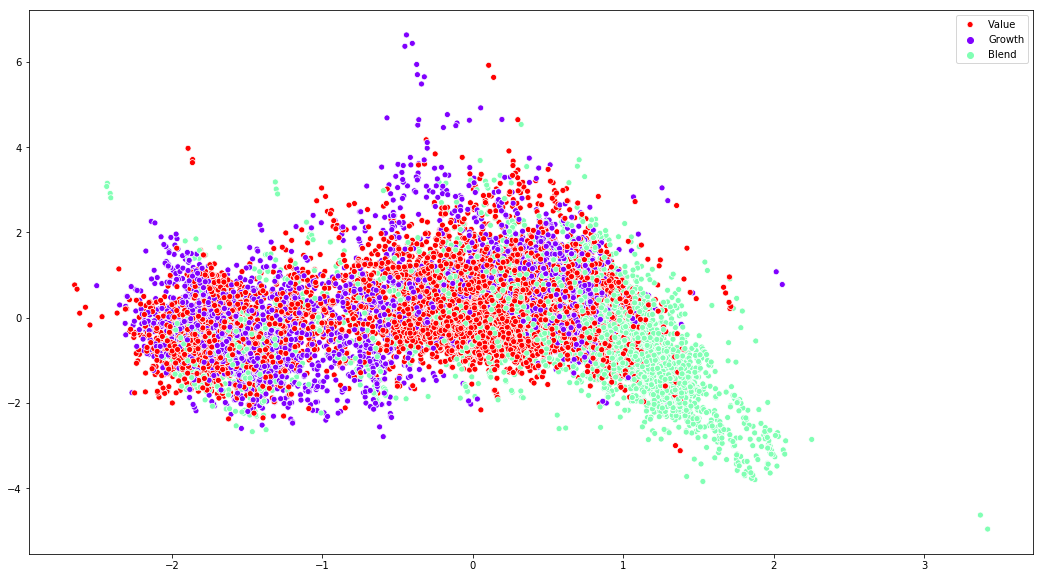

In [27]:
pca_x = PCA(n_components=2)
pca_x.fit(X_std)

X_pca = pca_x.transform(X_std)

std_x1 = StandardScaler()
std_x1.fit(X_pca)

X_pca_norm = std_x1.transform(X_pca)

plt.figure(figsize=(18,10))
sns.scatterplot(X_pca_norm[:,0], X_pca_norm[:,1], hue=list(Y), palette="rainbow")
plt.legend(labels=list(cache_mapping["investment"].labels.keys()))

print("We can see that data is not not linearly seprable when we do Linear PCA on the data.\
       \nHence We have to go for Kernel PCA")

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_norm, Y, test_size=0.35, random_state=42)

classifier1 = MLPClassifier(hidden_layer_sizes=(143,1,), max_iter= 800, random_state=9)
classifier1.fit(X_train, list(y_train))

y_pred = classifier1.predict(X_test)

print("Accuracy Score is {:0.4f}%".format(100*accuracy_score(list(y_test), list(y_pred))))
print("Recall Score is {:0.4f}%".format(100*recall_score(list(y_test), list(y_pred), average="micro")))
print("Precision Score is {:0.4f}%".format(100*precision_score(list(y_test), list(y_pred), average="micro")))

Accuracy Score is 57.4715%
Recall Score is 57.4715%
Precision Score is 57.4715%


# Kernel Principle Component Analysis

In [29]:
from sklearn.decomposition.kernel_pca import KernelPCA

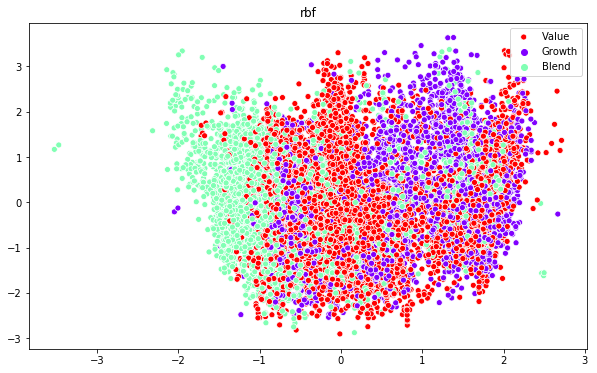

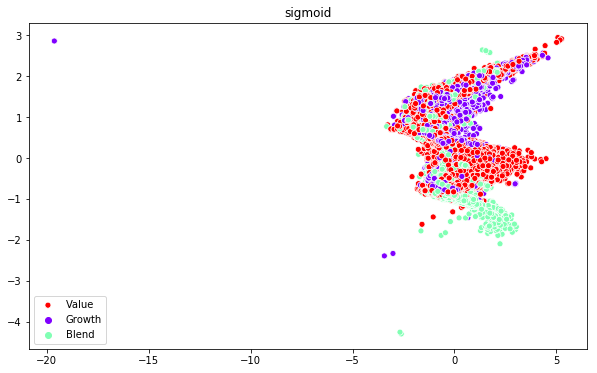

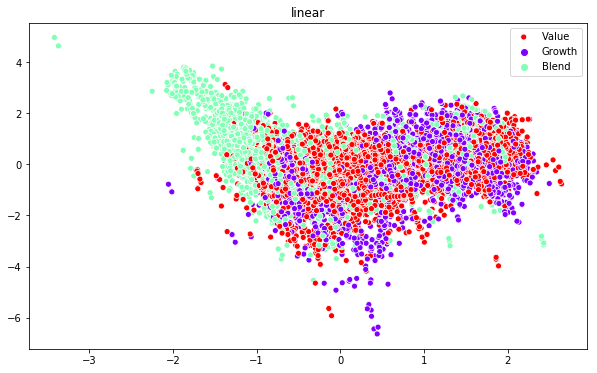

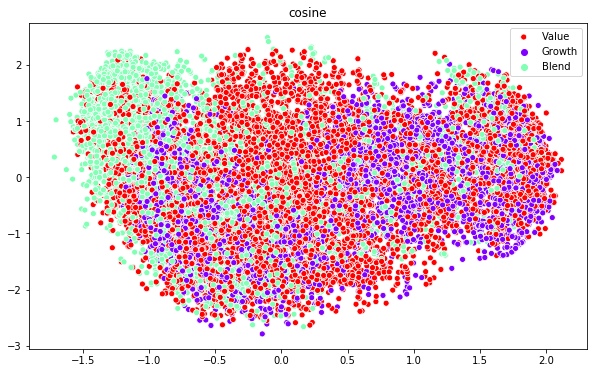

In [30]:
kernels = ["rbf", "sigmoid", "linear", "cosine"]

for kx in kernels:
    kpca_x = KernelPCA(n_components=2, kernel=kx, random_state=42, gamma=1e-8)
    kpca_x.fit(X_std)

    X_kpca = kpca_x.transform(X_std)

    std_x2 = StandardScaler()
    std_x2.fit(X_kpca)

    X_kpca_norm = std_x2.transform(X_kpca)

    plt.figure(figsize=(10,6))
    sns.scatterplot(X_kpca_norm[:,0], X_kpca_norm[:,1], hue=list(Y), palette="rainbow")
    
    plt.legend(labels=list(cache_mapping["investment"].labels.keys()))
    plt.title(kx)
    plt.show()


In [38]:
kernels = ["rbf", "linear", "cosine", "sigmoid"]
kernel_dict = {"rbf": 143, "linear":143 , "cosine":153 , "sigmoid":143}

for kx in kernels:
    kpca_x = KernelPCA(n_components=2, kernel=kx, random_state=42, gamma=1e-6)
    kpca_x.fit(X_std)

    X_kpca = kpca_x.transform(X_std)

    std_x2 = StandardScaler()
    std_x2.fit(X_kpca)

    X_kpca_norm = std_x2.transform(X_kpca)

    X_train, X_test, y_train, y_test = train_test_split(X_kpca_norm, Y, test_size=0.35, random_state=42)

    classifier1 = MLPClassifier(hidden_layer_sizes=(kernel_dict[kx],1,), max_iter= 800, random_state=9)
    classifier1.fit(X_train, list(y_train))

    y_pred = classifier1.predict(X_test)

    print("\n\n{} Kernel".format(kx))
    print("Accuracy Score is {:0.4f}%".format(100*accuracy_score(list(y_test), list(y_pred))))
    print("Recall Score is {:0.4f}%".format(100*recall_score(list(y_test), list(y_pred), average="micro")))
    print("Precision Score is {:0.4f}%".format(100*precision_score(list(y_test), list(y_pred), average="micro")))



rbf Kernel
Accuracy Score is 57.3863%
Recall Score is 57.3863%
Precision Score is 57.3863%


linear Kernel
Accuracy Score is 57.5567%
Recall Score is 57.5567%
Precision Score is 57.5567%


cosine Kernel
Accuracy Score is 53.5014%
Recall Score is 53.5014%
Precision Score is 53.5014%


sigmoid Kernel
Accuracy Score is 57.6078%
Recall Score is 57.6078%
Precision Score is 57.6078%


# Linear Discriminant Analysis

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/home/ayush/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


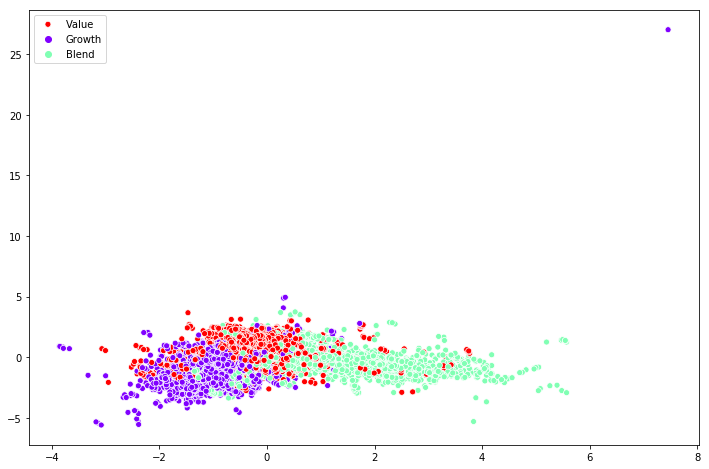

In [33]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_std , list(Y))

X_lda = lda.transform(X_std)

std_x3 = StandardScaler()
std_x3.fit(X_lda)

X_lda_norm = std_x3.transform(X_lda)

plt.figure(figsize=(12,8))
sns.scatterplot(X_lda_norm[:,0], X_lda_norm[:,1], hue=list(Y), palette="rainbow")
plt.legend(labels=list(cache_mapping["investment"].labels.keys()))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_lda_norm, Y, test_size=0.35, random_state=42)

classifier1 = MLPClassifier(hidden_layer_sizes=(155,1,), max_iter= 800, random_state=9)
classifier1.fit(X_train, list(y_train))

y_pred = classifier1.predict(X_test)

print("Accuracy Score is {:0.4f}%".format(100*accuracy_score(list(y_test), list(y_pred))))
print("Recall Score is {:0.4f}%".format(100*recall_score(list(y_test), list(y_pred), average="micro")))
print("Precision Score is {:0.4f}%".format(100*precision_score(list(y_test), list(y_pred), average="micro")))

Accuracy Score is 73.3174%
Recall Score is 73.3174%
Precision Score is 73.3174%
